# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

# <font color='blue'>Index</font>
- <font color='blue'>1. Initial Steps</font>
	- <font color='blue'>1.1 Imports</font>
	- <font color='blue'>1.2 Random Seeds</font>
	- <font color='blue'>1.3 Google Drive Connect</font>
	- <font color='blue'>1.4 Setting Paths</font>
	- <font color='blue'>1.5 Defining Generator</font>
	- <font color='blue'>1.6 Listing File Counts</font>
- <font color='blue'>2. Models</font>
	- <font color='blue'>2.1 Model 1 - </font>
		- <font color='blue'>2.1.1 Design, Compile & Summary</font>
		- <font color='blue'>2.1.2 Model Training</font>
		- <font color='blue'>2.1.3 Accuracy & Remarks</font>
		- <font color='blue'>2.1.4 Next Actions</font>
	- <font color='blue'>2.2 Model 2 - </font>
		- <font color='blue'>2.2.1 Design, Compile & Summary</font>
		- <font color='blue'>2.2.2 Model Training</font>
		- <font color='blue'>2.2.3 Accuracy & Remarks</font>
		- <font color='blue'>2.2.4 Next Actions</font>
	- <font color='blue'>2.3 Model 3 - </font>
		- <font color='blue'>2.3.1 Design, Compile & Summary</font>
		- <font color='blue'>2.3.2 Model Training</font>
		- <font color='blue'>2.3.3 Accuracy & Remarks</font>
		- <font color='blue'>2.3.4 Next Actions</font>
	- <font color='blue'>2.4 Model 4 - </font>
		- <font color='blue'>2.4.1 Design, Compile & Summary</font>
		- <font color='blue'>2.4.2 Model Training</font>
		- <font color='blue'>2.4.3 Accuracy & Remarks</font>
		- <font color='blue'>2.4.4 Next Actions</font>
	- <font color='blue'>2.5 Model 5 - </font>
		- <font color='blue'>2.5.1 Design, Compile & Summary</font>
		- <font color='blue'>2.5.2 Model Training</font>
		- <font color='blue'>2.5.3 Accuracy & Remarks</font>
		- <font color='blue'>2.5.4 Next Actions</font>
	- <font color='blue'>2.6 Model 6 - </font>
		- <font color='blue'>2.6.1 Design, Compile & Summary</font>
		- <font color='blue'>2.6.2 Model Training</font>
		- <font color='blue'>2.6.3 Accuracy & Remarks</font>
		- <font color='blue'>2.6.4 Next Actions</font>
- <font color='blue'>3. Conclusion & Final Selection</font>

## <font color='blue'>1. Initial Steps</font>

### <font color='blue'>1.1 Imports</font>

In [38]:
import numpy as np
import os
import imageio.v2 as imageio
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

from keras.applications import mobilenet

### <font color='blue'>1.2 Random Seeds</font>

We set the random seed so that the results don't vary drastically.

In [39]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from google.colab import drive
drive.mount('/content/gdrive')In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

### <font color='blue'>1.3 Google Drive Connect</font>

In [40]:
# from google.colab import drive
# drive.mount('/content/gdrive')

### <font color='blue'>1.4 Setting Paths</font>

In [41]:
# train_doc = np.random.permutation(open('/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train.csv').readlines())
# val_doc = np.random.permutation(open('/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val.csv').readlines())

train_doc = np.random.permutation(open('G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\train.csv').readlines())
val_doc = np.random.permutation(open('G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\val.csv').readlines())

batch_size = 64 #experiment with the batch size 16, 32, 64

### <font color='blue'>1.5 Defining Generator</font>

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [42]:
def generator(source_path, folder_list, batch_size, img_idx, shape_h, shape_w):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # img_idx = [1,4,7,10,13,16,19,22,25,28] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        # left over batches which should be handled separately
        leftover_batches = len(t) - num_batches * batch_size

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), shape_h, shape_w, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image, (shape_h, shape_w))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                    batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                    batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches
        # write the code for the remaining data points which are left after full batches
        if leftover_batches != 0:
            for batch in range(num_batches):
                # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_data = np.zeros((batch_size,len(img_idx),shape_h, shape_w,3))
                # batch_labels is the one hot representation of the output: 10 videos with 5 columns as classes
                batch_labels = np.zeros((batch_size,5))
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path +'/'+t[batch * batch_size + folder].split(';')[0])
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in

                        image = imageio.imread(source_path +'/'+t[batch * batch_size + folder].split(';')[0] +'/'+imgs[item]).astype(np.float32)
                        image = resize(image, (shape_h,shape_w))

                        batch_data[folder,idx,:,:,0] = (image[:,:,0]) - 104
                        batch_data[folder,idx,:,:,1] = (image[:,:,1]) - 117
                        batch_data[folder,idx,:,:,2] = (image[:,:,2]) - 123

                    #Fill the one hot encoding stuff where we maintain the label
                    batch_labels[folder, int(t[batch * batch_size + folder].split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

### <font color='blue'>1.6 Listing File Counts</font>

In [43]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
# train_path = '/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/train'
# val_path = '/content/gdrive/My Drive/Personal/upGrad/MS/Recurrent Neural Networks/Project_data/val'
train_path = 'G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\train'
val_path = 'G:\\My Drive\\Personal\\upGrad\\MS\\Recurrent Neural Networks\\Project_data\\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


In [44]:
img_idx = list(range(1,30,3))
shape_h = 50
shape_w = 50
batch_size = 1
test_gen = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
d = next(test_gen)[0]

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


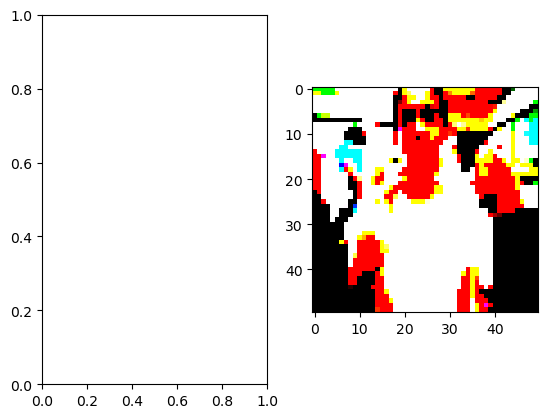

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.imshow(d[0,9,:,:,:])
# axes[1].imshow(d[3,15,:,:,:])

## <font color='blue'>2. Models</font>

### <font color='blue'>2.1 Model 1 - </font>

#### <font color='blue'>2.1.1 Design, Compile & Summary</font>

In [47]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 50
shape_w = 50
batch_size = 1
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 10, 50, 50, 16)    1312      
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 5, 25, 25, 16)     0         
 ng3D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 5, 25, 25, 16)     64        
 tchNormalization)                                               
                                                                 
 conv3d_25 (Conv3D)          (None, 5, 25, 25, 32)     13856     
                                                                 
 max_pooling3d_25 (MaxPooli  (None, 2, 12, 12, 32)     0         
 ng3D)                                                           
                                                      

#### <font color='blue'>2.1.2 Model Training</font>

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [51]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = 'C:\\Temp\\RNN\\' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\train ; batch size = 1


C:\Users\ASyed\AppData\Local\Temp\ipykernel_8196\2741796141.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
663/663 [==============================] - ETA: 0s - loss: 1.8976 - categorical_accuracy: 0.3952Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 1

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00001-1.89764-0.39517-2.16167-0.49000.h5
663/663 [==============================] - 168s 249ms/step - loss: 1.8976 - categorical_accuracy: 0.3952 - val_loss: 2.1617 - val_categorical_accuracy: 0.4900 - lr: 0.0010
Epoch 2/15
663/663 [==============================] - ETA: 0s - loss: 1.0559 - categorical_accuracy: 0.5958
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00002-1.05591-0.59578-1.08228-0.67000.h5
663/663 [==============================] - 181s 274ms/step - loss: 1.0559 - categorical_accuracy: 0.5958 - val_loss: 1.0823 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 3/15
663/663 [==============================] - ETA: 0s - loss: 0.6762 - categorical_a

#### <font color='blue'>2.1.3 Accuracy & Remarks</font>

#### <font color='blue'>2.1.4 Next Actions</font>

### <font color='blue'>2.2 Model 2 - </font>

#### <font color='blue'>2.2.1 Design, Compile & Summary</font>

In [ ]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 100
shape_w = 100
batch_size = 32
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, image_height, image_width, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#### <font color='blue'>2.2.2 Model Training</font>

In [52]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = 'C:\\Temp\\RNN\\' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 10, 100, 100, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_27 (MaxPooli  (None, 5, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 batch_normalization_27 (Ba  (None, 5, 50, 50, 16)     64        
 tchNormalization)                                               
                                                                 
 conv3d_28 (Conv3D)          (None, 5, 50, 50, 32)     13856     
                                                                 
 max_pooling3d_28 (MaxPooli  (None, 2, 25, 25, 32)     0         
 ng3D)                                                

C:\Users\ASyed\AppData\Local\Temp\ipykernel_8196\4088393871.py:35: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 1.3931 - categorical_accuracy: 0.5551Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 32

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00001-1.39308-0.55506-43.50549-0.23438.h5
21/21 [==============================] - 183s 9s/step - loss: 1.3931 - categorical_accuracy: 0.5551 - val_loss: 43.5055 - val_categorical_accuracy: 0.2344 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 0.3861 - categorical_accuracy: 0.8661
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00002-0.38611-0.86607-24.60771-0.32031.h5
21/21 [==============================] - 180s 9s/step - loss: 0.3861 - categorical_accuracy: 0.8661 - val_loss: 24.6077 - val_categorical_accuracy: 0.3203 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 0.1460 - categorical_accuracy: 0.

#### <font color='blue'>2.2.3 Accuracy & Remarks</font>

#### <font color='blue'>2.2.4 Next Actions</font>

As the difference between Categorical Accuracy (1.0) and ValidationAccuracy (0.89) is high, we will introduce dropout to overcome overfitting

### <font color='blue'>2.3 Model 3 - </font>

#### <font color='blue'>2.3.1 Design, Compile & Summary</font>

In [ ]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 100
shape_w = 100
batch_size = 32
num_classes = 5

model = Sequential()

model.add(Conv3D(16, (3,3,3), padding='same', input_shape=(frames, shape_h, shape_w, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#### <font color='blue'>2.3.2 Model Training</font>

In [53]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = 'C:\\Temp\\RNN\\' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_30 (Conv3D)          (None, 10, 100, 100, 16   1312      
                             )                                   
                                                                 
 max_pooling3d_30 (MaxPooli  (None, 5, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 5, 50, 50, 16)     0         
                                                                 
 batch_normalization_30 (Ba  (None, 5, 50, 50, 16)     64        
 tchNormalization)                                               
                                                                 
 conv3d_31 (Conv3D)          (None, 5, 50, 50, 32)     13856     
                                                     

C:\Users\ASyed\AppData\Local\Temp\ipykernel_8196\824533343.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.0993 - categorical_accuracy: 0.3155Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 32

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00001-2.09931-0.31548-15.87268-0.25000.h5
21/21 [==============================] - 187s 9s/step - loss: 2.0993 - categorical_accuracy: 0.3155 - val_loss: 15.8727 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.3849 - categorical_accuracy: 0.4583
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00002-1.38489-0.45833-3.25232-0.25000.h5
21/21 [==============================] - 195s 10s/step - loss: 1.3849 - categorical_accuracy: 0.4583 - val_loss: 3.2523 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.1799 - categorical_accuracy: 0.5

#### <font color='blue'>2.3.3 Accuracy & Remarks</font>

#### <font color='blue'>2.3.4 Next Actions</font>

Due to the low validation accuracy above,
- batch_size = 64
- changing the architecture to start with 32 going into 256
- ReduceLROnPlateau

### <font color='blue'>2.4 Model 4 - </font>

#### <font color='blue'>2.4.1 Design, Compile & Summary</font>

In [ ]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 100
shape_w = 100
batch_size = 64
num_classes = 5

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(frames, shape_h, shape_w, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#### <font color='blue'>2.4.2 Model Training</font>

In [54]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = 'C:\\Temp\\RNN\\' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_33 (Conv3D)          (None, 10, 100, 100, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_33 (MaxPooli  (None, 5, 50, 50, 32)     0         
 ng3D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 5, 50, 50, 32)     0         
                                                                 
 batch_normalization_33 (Ba  (None, 5, 50, 50, 32)     128       
 tchNormalization)                                               
                                                                 
 conv3d_34 (Conv3D)          (None, 5, 50, 50, 64)     55360     
                                                     

C:\Users\ASyed\AppData\Local\Temp\ipykernel_8196\1833668871.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 2.1916 - categorical_accuracy: 0.3267 Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 64

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00001-2.19160-0.32670-47.58380-0.28125.h5
11/11 [==============================] - 277s 27s/step - loss: 2.1916 - categorical_accuracy: 0.3267 - val_loss: 47.5838 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.2346 - categorical_accuracy: 0.5611 
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00002-1.23461-0.56108-42.14281-0.21875.h5
11/11 [==============================] - 256s 25s/step - loss: 1.2346 - categorical_accuracy: 0.5611 - val_loss: 42.1428 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 0.9868 - categorical_accuracy

#### <font color='blue'>2.4.3 Accuracy & Remarks</font>

#### <font color='blue'>2.4.4 Next Actions</font>

Cropping the image to 50 x 50

### <font color='blue'>2.5 Model 5 - </font>

#### <font color='blue'>2.5.1 Design, Compile & Summary</font>

In [ ]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 50
shape_w = 50
batch_size = 64
num_classes = 5

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', input_shape=(frames, shape_h, shape_w, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(64, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(128, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#### <font color='blue'>2.5.2 Model Training</font>

In [55]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = 'C:\\Temp\\RNN\\' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 10, 50, 50, 32)    2624      
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 5, 25, 25, 32)     0         
 ng3D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 5, 25, 25, 32)     0         
                                                                 
 batch_normalization_36 (Ba  (None, 5, 25, 25, 32)     128       
 tchNormalization)                                               
                                                                 
 conv3d_37 (Conv3D)          (None, 5, 25, 25, 64)     55360     
                                                                 
 max_pooling3d_37 (MaxPooli  (None, 2, 12, 12, 64)   

C:\Users\ASyed\AppData\Local\Temp\ipykernel_8196\2628521629.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
11/11 [==============================] - ETA: 0s - loss: 2.0928 - categorical_accuracy: 0.3068 Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 64

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00001-2.09285-0.30682-38.74179-0.18750.h5
11/11 [==============================] - 258s 25s/step - loss: 2.0928 - categorical_accuracy: 0.3068 - val_loss: 38.7418 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 2/15
11/11 [==============================] - ETA: 0s - loss: 1.6745 - categorical_accuracy: 0.4162 
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00002-1.67454-0.41619-22.17600-0.22656.h5
11/11 [==============================] - 230s 23s/step - loss: 1.6745 - categorical_accuracy: 0.4162 - val_loss: 22.1760 - val_categorical_accuracy: 0.2266 - lr: 0.0010
Epoch 3/15
11/11 [==============================] - ETA: 0s - loss: 1.3853 - categorical_accuracy

#### <font color='blue'>2.5.3 Accuracy & Remarks</font>

#### <font color='blue'>2.5.4 Next Actions</font>

As we got an error starting with 32 filters, reducing it to start with 8

### <font color='blue'>2.6 Model 6 - </font>

#### <font color='blue'>2.6.1 Design, Compile & Summary</font>

In [ ]:
img_idx = list(range(1,30,3))
frames = len(img_idx)
shape_h = 50
shape_w = 50
batch_size = 32
num_classes = 5

model = Sequential()

model.add(Conv3D(8, (3,3,3), padding='same', input_shape=(frames, shape_h, shape_w, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(16, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

optimiser = "adam"
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

#### <font color='blue'>2.6.2 Model Training</font>

In [56]:
train_generator = generator(train_path, train_doc, batch_size, img_idx, shape_h, shape_w)
val_generator = generator(val_path, val_doc, batch_size, img_idx, shape_h, shape_w)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = 'C:\\Temp\\RNN\\' + model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 max_pooling3d_39 (MaxPooli  (None, 5, 25, 25, 8)      0         
 ng3D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 5, 25, 25, 8)      0         
                                                                 
 batch_normalization_39 (Ba  (None, 5, 25, 25, 8)      32        
 tchNormalization)                                               
                                                                 
 conv3d_40 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 2, 12, 12, 16)   

C:\Users\ASyed\AppData\Local\Temp\ipykernel_8196\149713886.py:61: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/15
21/21 [==============================] - ETA: 0s - loss: 2.1624 - categorical_accuracy: 0.2485Source path =  G:\My Drive\Personal\upGrad\MS\Recurrent Neural Networks\Project_data\val ; batch size = 32

Epoch 1: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00001-2.16245-0.24851-6.90674-0.25000.h5
21/21 [==============================] - 185s 9s/step - loss: 2.1624 - categorical_accuracy: 0.2485 - val_loss: 6.9067 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
21/21 [==============================] - ETA: 0s - loss: 1.9454 - categorical_accuracy: 0.2976
Epoch 2: saving model to C:\Temp\RNN\model_init_2024-03-0422_32_28.038415\model-00002-1.94536-0.29762-3.75097-0.25000.h5
21/21 [==============================] - 163s 8s/step - loss: 1.9454 - categorical_accuracy: 0.2976 - val_loss: 3.7510 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
21/21 [==============================] - ETA: 0s - loss: 1.6242 - categorical_accuracy: 0.3631

#### <font color='blue'>2.6.3 Accuracy & Remarks</font>

#### <font color='blue'>2.6.4 Next Actions</font>

## <font color='blue'>3. Conclusion & Final Selection</font>